In [23]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [25]:
df1=pd.read_csv('data_a.csv')
df2=pd.read_csv('data_c.csv')
df3=pd.read_csv('data_p.csv')

In [27]:
df = pd.concat([df1, df2, df3])

In [29]:
df.head()

,smiles,emission
0,CC(C)(CC1C=C2C3)C(N=1[Zn](N2C(C=3)=C1)(N2C3C4)...,605.0
1,CC(C)(CC1C=C(C=C2)NC2=CC2C3)C(N=1)=CC(=CC1)NC=...,634.0
2,CC(C)(CC1/C=C(\N2C3=C4)C=C3)/C(N=1)=C/C(=CC1)N...,610.0
3,CC(C)(CC1C=C2C3)C(N=1[Zn](N1C45)(N2C2C=3)N(C(C...,607.0
4,CC(C)(CC1C=C(NC2=CC34)C=C2)C(N=1)=CC(NC1C(C(C=...,637.0


In [31]:
df.isnull().sum()

smiles       0
emission    97
dtype: int64

In [33]:
print((df['smiles'] == 0).sum())

0


In [35]:
mean_value = df['emission'].mean()
min_value = df['emission'].min()
max_value= df['emission'].max()
print(f"mean:{int(mean_value)} max:{int(max_value)}, min:{int(min_value)}")

mean:545 max:1045, min:296


In [37]:
df = df.fillna(695)

In [39]:
df.head()

,smiles,emission
0,CC(C)(CC1C=C2C3)C(N=1[Zn](N2C(C=3)=C1)(N2C3C4)...,605.0
1,CC(C)(CC1C=C(C=C2)NC2=CC2C3)C(N=1)=CC(=CC1)NC=...,634.0
2,CC(C)(CC1/C=C(\N2C3=C4)C=C3)/C(N=1)=C/C(=CC1)N...,610.0
3,CC(C)(CC1C=C2C3)C(N=1[Zn](N1C45)(N2C2C=3)N(C(C...,607.0
4,CC(C)(CC1C=C(NC2=CC34)C=C2)C(N=1)=CC(NC1C(C(C=...,637.0


In [41]:
df['emission'].isnull().any()

False

In [43]:
# pipeline for cleaning dataset from duplicates and unvalid SMILES by converting SMILES strings to canonical SMILES
def canonicalize(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            return Chem.MolToSmiles(mol, canonical=True)
    except:
        return None  
    return None
    
# applying the canonicalization
df['canonical_smiles'] = df['smiles'].apply(canonicalize)

#dropping duplicates based on the canonical smiles

df_unique = df.drop_duplicates(subset='canonical_smiles')

# Save the cleaned data
df_unique.to_csv("your_smiles_dataset_unique.csv", index=False)

print(f"original count: {len(df)}")
print(f"unique molecules: {len(df_unique)}")
print(f"duplicates detected: {len(df) - len(df_unique)}")

original count: 4802
unique molecules: 3283
duplicates detected: 1519


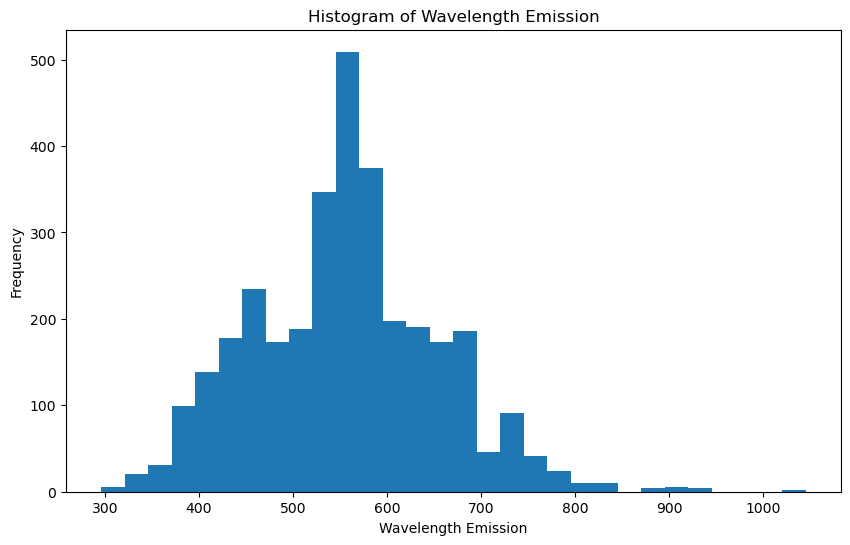

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(df_unique['emission'], bins=30)
plt.title('Histogram of Wavelength Emission')
plt.xlabel('Wavelength Emission')
plt.ylabel('Frequency')
plt.savefig('distribition.pdf')
plt.show()

In [45]:
#defining target and feature
smiles_list = df_unique['smiles']
targets = df_unique['emission']

In [47]:
#defining function for using morgan generator

morgan_gen = GetMorganGenerator(radius=2, fpSize=4096)

def smiles_to_morgan_fp(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(morgan_gen.GetFingerprint(mol))
    except:
        pass
    return None

In [49]:
##converting smiles to morgan and generating numerical arrays for ML
fps = [smiles_to_morgan_fp(smiles) for smiles in df_unique['smiles']]  
valid_idx = [i for i, fp in enumerate(fps) if fp is not None]    
X = np.array([list(fps[i]) for i in valid_idx])                  
y = df_unique.iloc[valid_idx]['emission'].values                       

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [51]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [55]:
#performance of the model for training set
y_train_pred = rf.predict(X_train) 

RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
R2 = r2_score(y_train, y_train_pred)

print(f"RMSE: {RMSE:.2f}")
print(f"R² Score: {R2:.2f}")

RMSE: 14.78
R² Score: 0.98


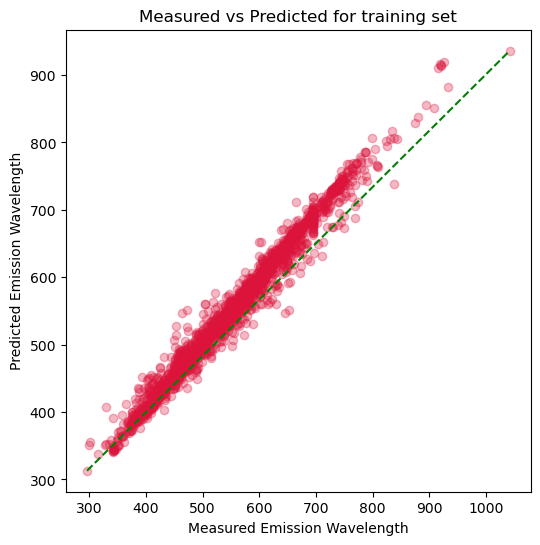

In [129]:
plt.figure(figsize=(6,6))
plt.scatter(y_train, y_train_pred, alpha=0.3, color='crimson')
plt.plot([y_train.min(), y_train.max()], [y_train_pred.min(),y_train_pred.max()], '--g')
plt.xlabel("Measured Emission Wavelength")
plt.ylabel("Predicted Emission Wavelength")
plt.title("Measured vs Predicted for training set")
plt.savefig('Final_graph.pdf')
plt.show()

In [89]:
#performance of the model for test set
y_test_pred = rf.predict(X_test)

RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))
R2 = r2_score(y_test, y_test_pred)

print(f"RMSE: {RMSE:.2f}")
print(f"R² Score: {R2:.2f}")

RMSE: 39.92
R² Score: 0.86


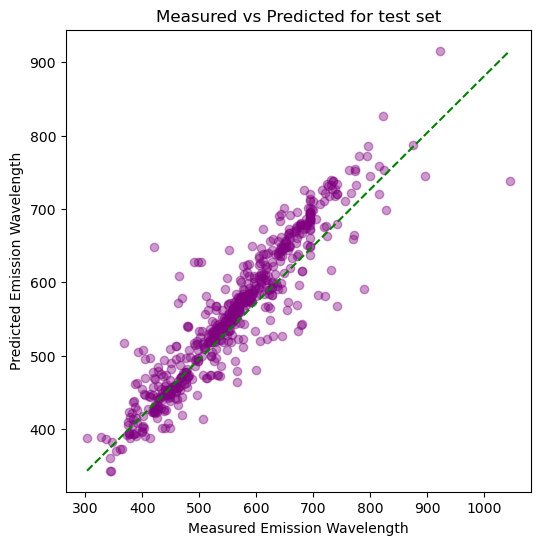

In [117]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.4, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test_pred.min(),y_test_pred.max()], '--g')
plt.xlabel("Measured Emission Wavelength")
plt.ylabel("Predicted Emission Wavelength")
plt.title("Measured vs Predicted for test set")
#plt.savefig('Final_graph.pdf')
plt.show()

In [103]:
def predict_wavelength_from_smiles(smiles, model, morgan_gen):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return "Invalid SMILES string; please enter a valis SMILES string"
            
        fp = list(morgan_gen.GetFingerprint(mol))
        fp_array = np.array(fp).reshape(1, -1)
        prediction = model.predict(fp_array)[0]
        return f"Predicted emission wavelength: {prediction:.2f} nm"
        
    except Exception as e:
        return f"Error during prediction: {str(e)}"


if __name__ == '__main__':
    while True:
        user_input = input("Enter a SMILES string or type exit to quit: ").strip()
        if user_input.lower() == 'exit':
            break
        result = predict_wavelength_from_smiles(user_input, rf, morgan_gen)
        print(result)

Enter a SMILES string or type exit to quit:  exit
